In [1]:
from Pipeline import BLEPipeline, WifiPipeline

# General data processing
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

# ML libraries
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import roc_curve, roc_auc_score

# System libraries
from itertools import izip, combinations
import random, time

# Warning filtering
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
plt.rcParams.update({'figure.max_open_warning': 0})

# Create dataset

In [2]:
time_start = time.time()

In [3]:
w = WifiPipeline()

In [4]:
# w.extract_packet_features(create_master=True)

In [5]:
df = w.make_dataframe()

Router     101880
Mini        75782
Dropcam     45912
Kasa        17156
Netcam2      3056
Netcam3      2961
Netcam1      2314
Switch2      2204
Switch1      1963
Switch3      1955
Insight      1738
Switch4      1504
Lifx2         545
Lifx1         495
TpPlug        366
TpBulb        191
Name: Name, dtype: int64


## Resample

### Downsampling

In [6]:
# Take out packets from router
df = df[df["DeviceType"]!="router"]

df_train = df[df['Set']=='train']

# List variables that do not work with resampling methods
dataframe_vars = {'Name', 'SourceAddr', 'Set', 'SubtypeNum'}
onehotEncoded_vars = {'Belkin', 'Data', 'Dropcam', 
                      'Lifi', 'Netgear', 'QoS_Data', 'QoS_Null', 'Tp-link'}
response_vars = {"DeviceType","bulb","camera","router","plug"}

# Prep X, y
y = df_train["DeviceType"]
col_drop = response_vars | dataframe_vars | set(['Subtype', 'Vendor'])
X = df_train.drop(col_drop, axis=1)

In [7]:
df_train['DeviceType'].value_counts()

plug      83642
camera    51282
bulb        686
Name: DeviceType, dtype: int64

### Create downsampled trial dataframes

In [8]:
df_trials = []
num_trials = 10
for i in range(0,num_trials):
    # Down
    df_downsampled = w.downsample(X, y, df[df["Set"]=="test"])
    df_trials.append(df_downsampled)

In [9]:
# Wifi: Define which features to use
features_list = [
        # Packet info
        "PacketLength", "Time",
        
        # Vendor 
         "Belkin", "Dropcam", "Lifi", "Netgear", "Tp-link",
    
        # 802.11 Data subtype
        "Data", "QoS_Data", "QoS_Null",

        # Associated Packets
        "Assoc_Packets"]

# Define what the response classes are
y_list = ["camera", "bulb", "plug"]

# Run trials

In [10]:
trial_results = []
for i, trial in enumerate(df_trials):
    print "Trial", i+1
    result = w.one_vs_all_classify(trial, features_list, y_list)
    trial_results.append(result)

Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 10


## Reports/Plots

In [11]:
df_alloutput = w.store_trial_results(trial_results)

In [17]:
w.create_csv_results('wifi', trial_results)

In [14]:
df_performance_device = w.report_metrics_across('Device', df_alloutput)
display(df_performance_device)

,Accuracy,SD_Accuracy,CI_Accuracy,TPR,SD_TPR,CI_TPR,FPR,SD_FPR,CI_FPR,FNR,SD_FNR,CI_FNR,Precision,SD_Precision,CI_Precision
plug,0.695436,0.207251,0.076971,0.507130,0.208206,0.077326,0.287521,0.213850,0.079422,0.492870,0.208206,0.077326,0.271571,0.238868,0.088713
bulb,0.934971,0.089331,0.033177,0.945076,0.079566,0.029550,0.065279,0.091797,0.034092,0.054924,0.079566,0.029550,0.506160,0.318999,0.118473
camera,0.263198,0.131332,0.048775,0.202673,0.156568,0.058148,0.232629,0.173983,0.064615,0.797327,0.156568,0.058148,0.870180,0.083620,0.031056


In [15]:
df_performance_classifier = w.report_metrics_across('Classifier', df_alloutput)
display(df_performance_classifier)

,Accuracy,SD_Accuracy,CI_Accuracy,TPR,SD_TPR,CI_TPR,FPR,SD_FPR,CI_FPR,FNR,SD_FNR,CI_FNR,Precision,SD_Precision,CI_Precision
KNN,0.654265,0.218813,0.081265,0.556910,0.201143,0.074703,0.263749,0.160674,0.059673,0.443090,0.201143,0.074703,0.433653,0.357672,0.132836
RF,0.652246,0.354821,0.131777,0.568174,0.374636,0.139136,0.111548,0.126808,0.047095,0.431826,0.374636,0.139136,0.643270,0.289802,0.107630
LDA,0.587094,0.362224,0.134526,0.529795,0.425129,0.157889,0.210134,0.240684,0.089388,0.470205,0.425129,0.157889,0.570988,0.344488,0.127940


In [18]:
device_types = ['bulb', 'camera', 'plug']
classifiers = ['KNN', 'LDA', 'RF']

### AUC

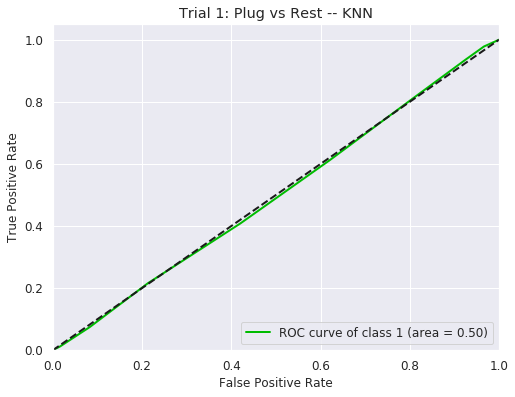

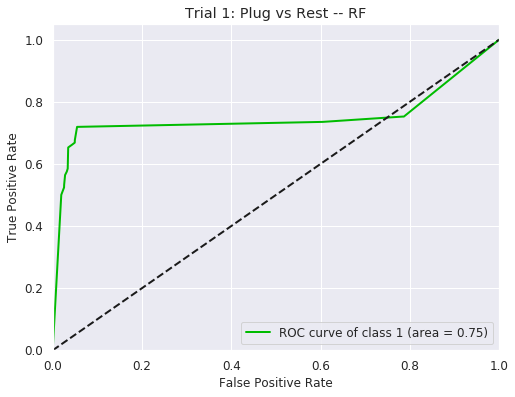

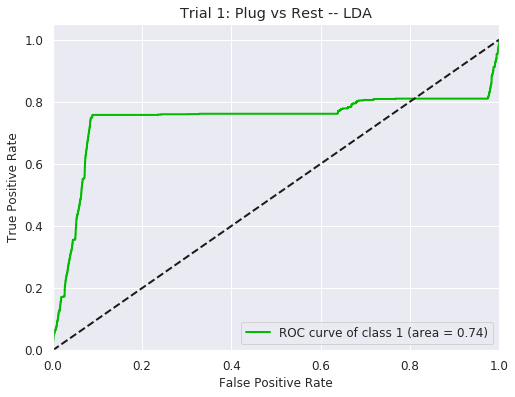

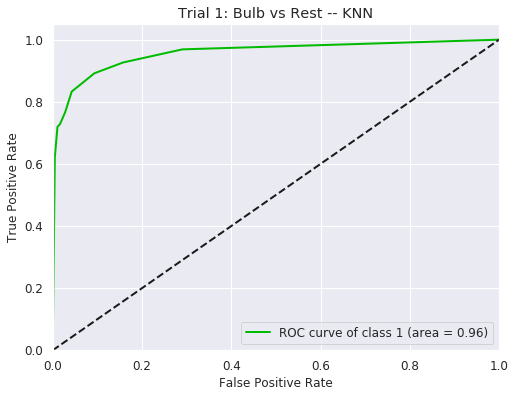

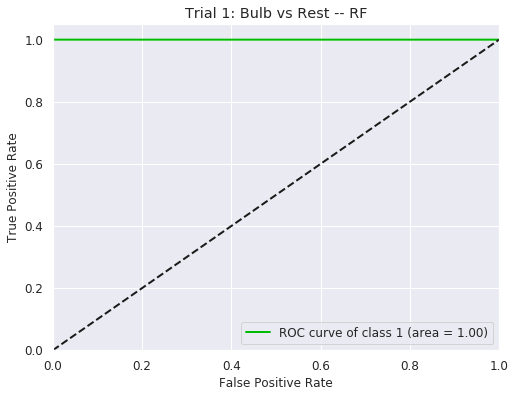

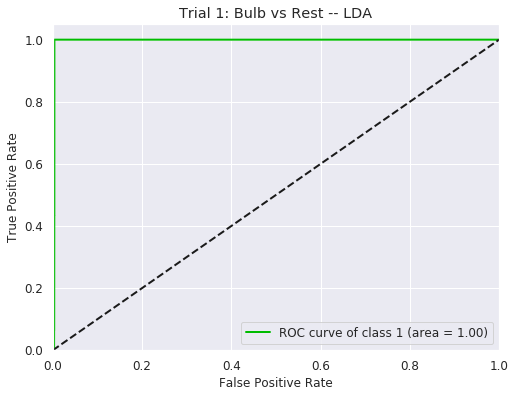

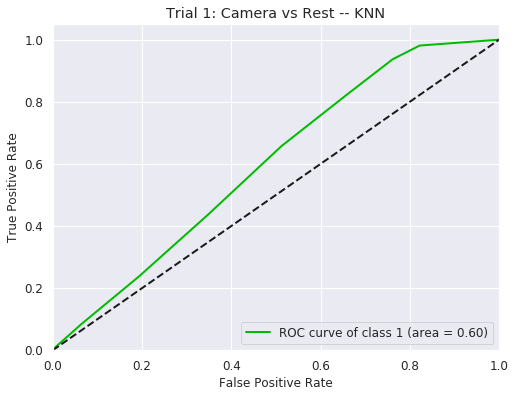

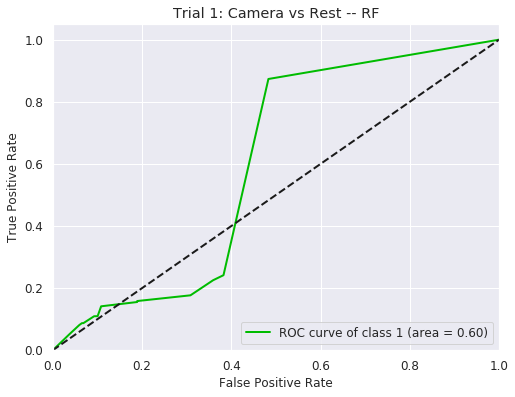

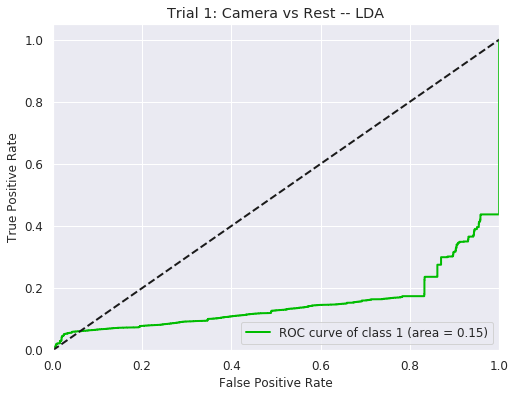

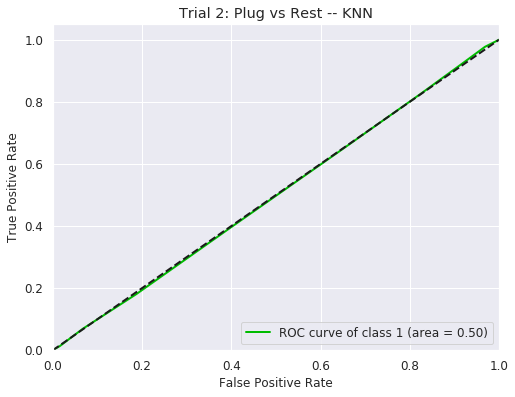

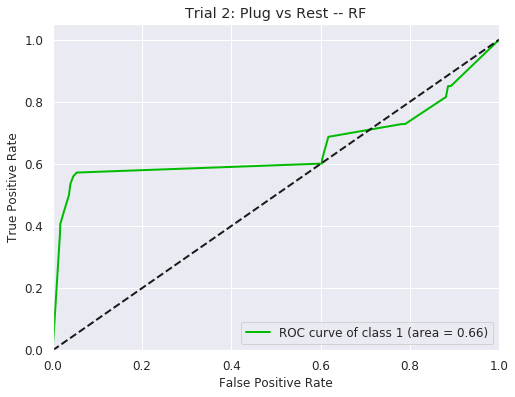

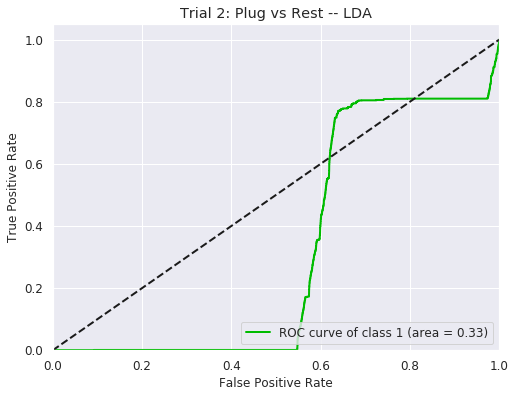

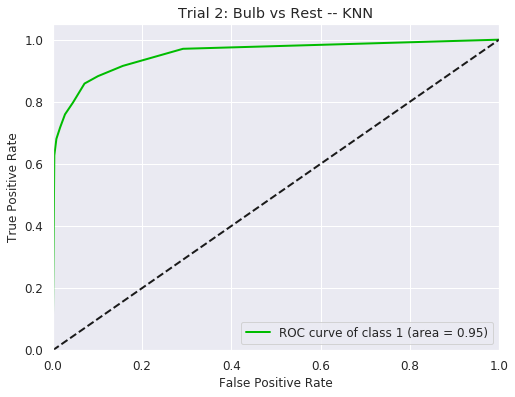

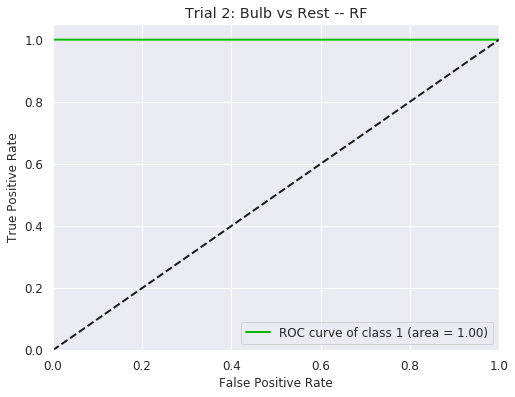

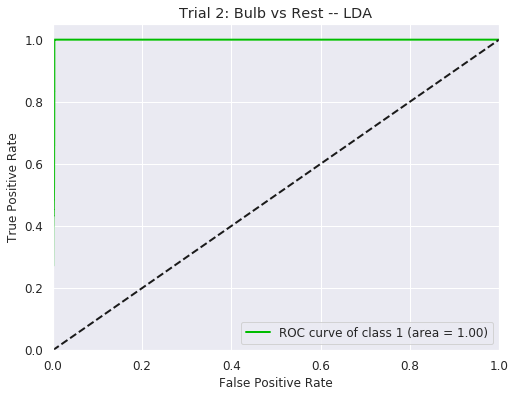

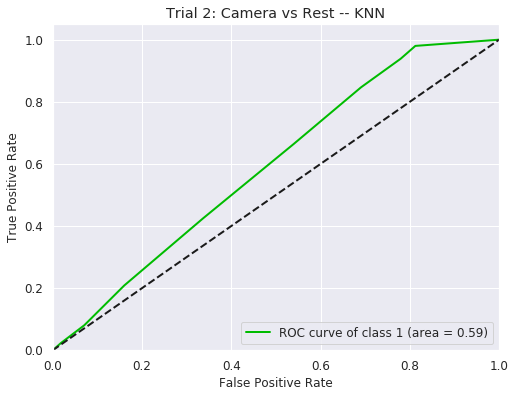

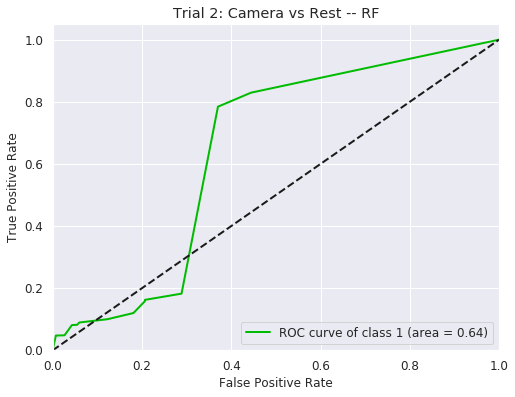

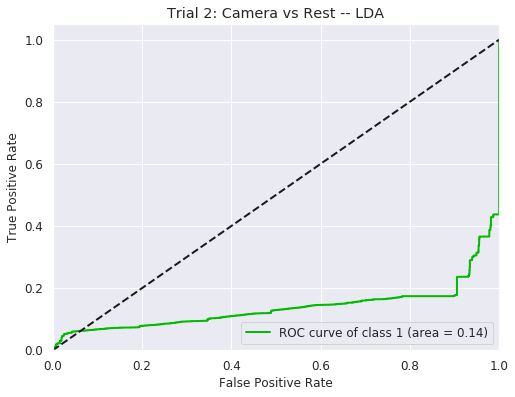

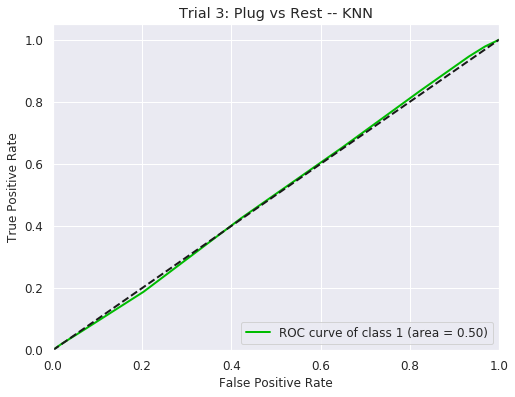

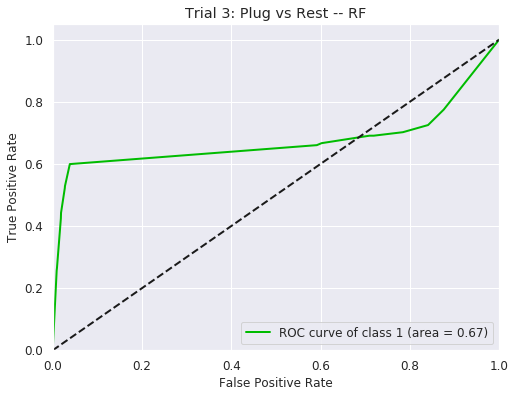

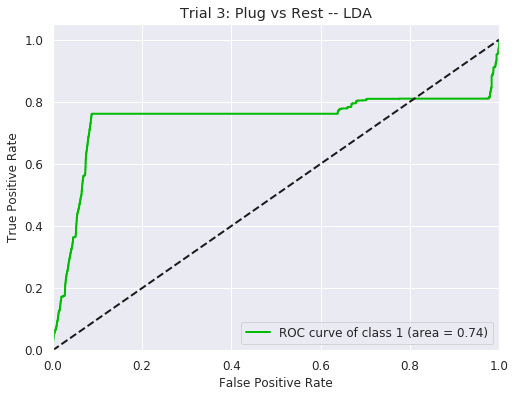

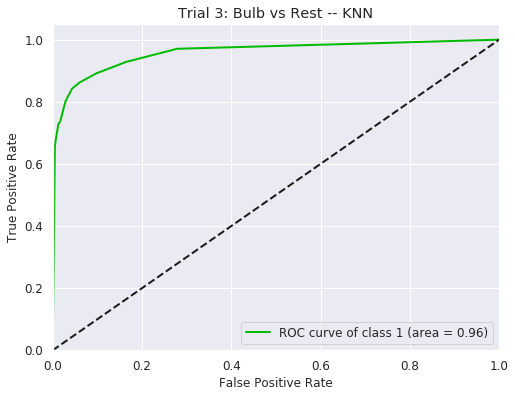

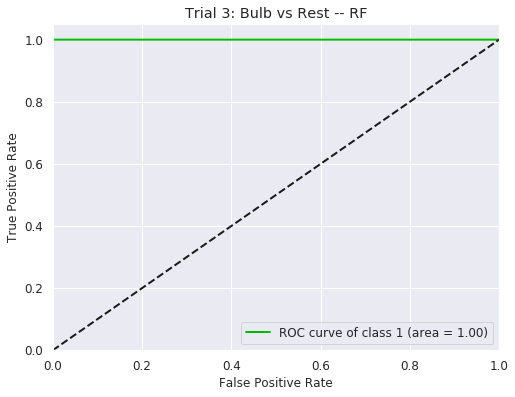

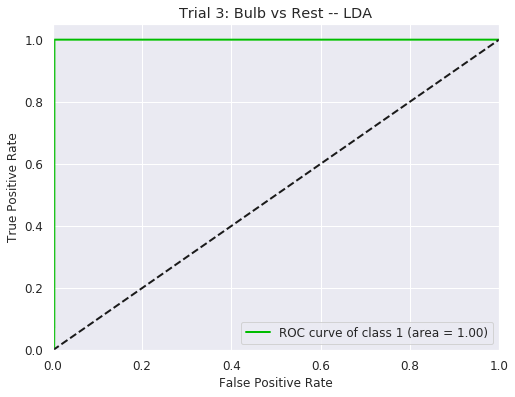

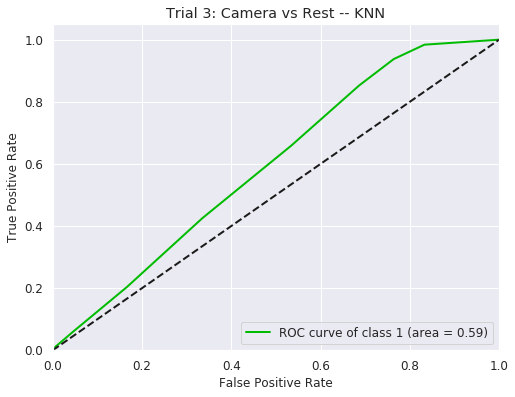

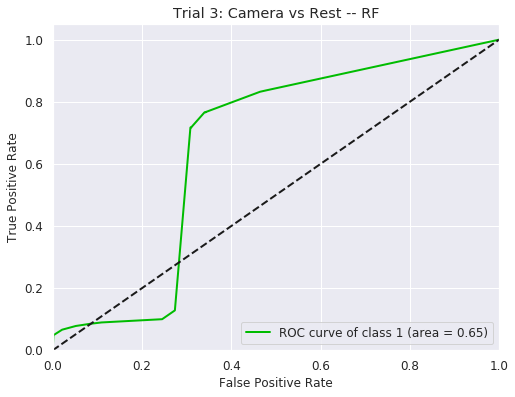

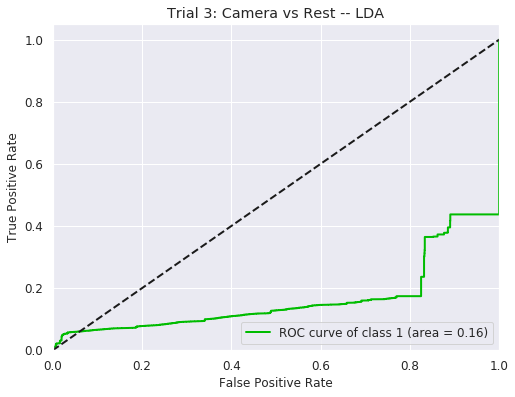

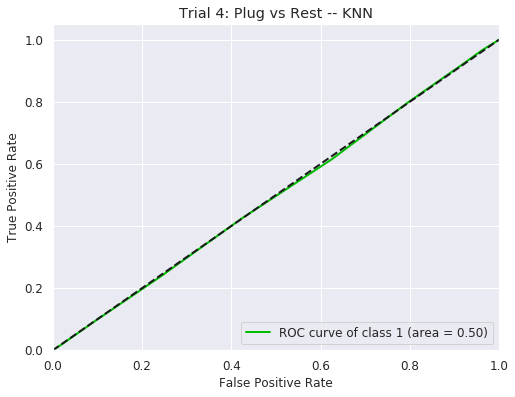

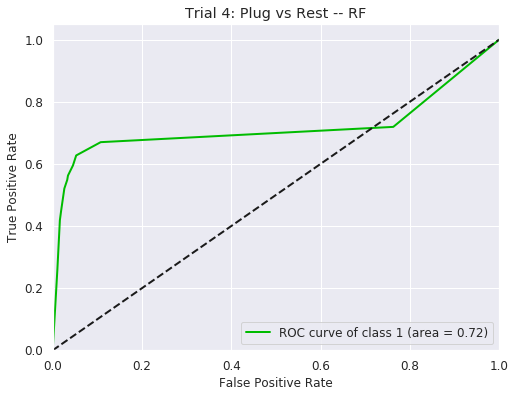

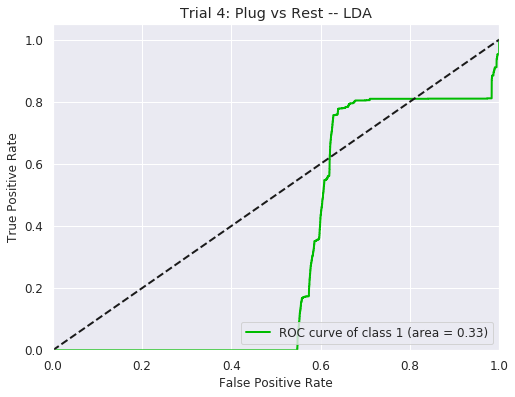

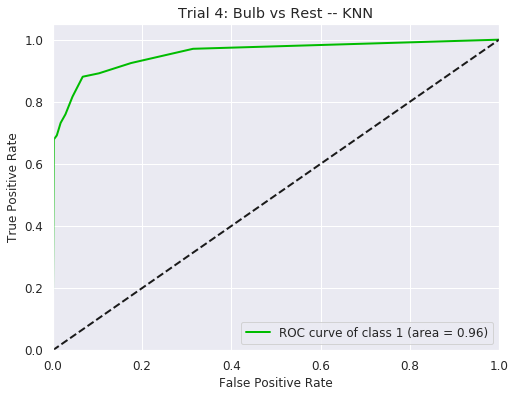

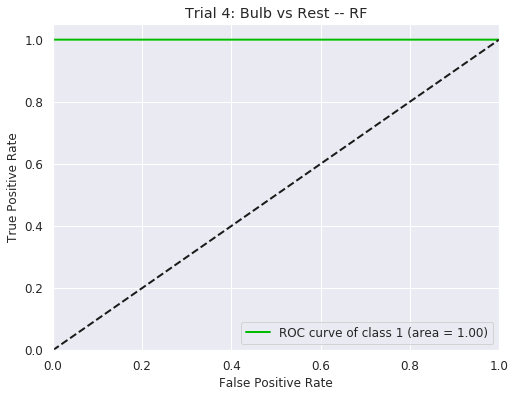

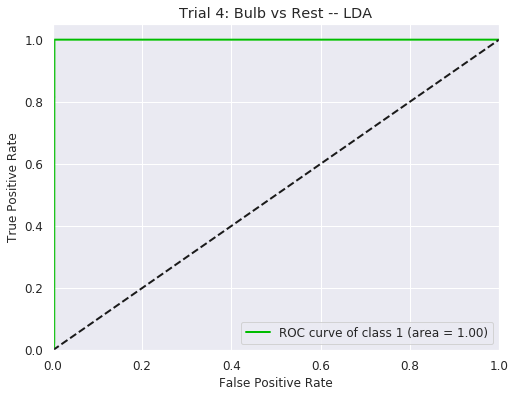

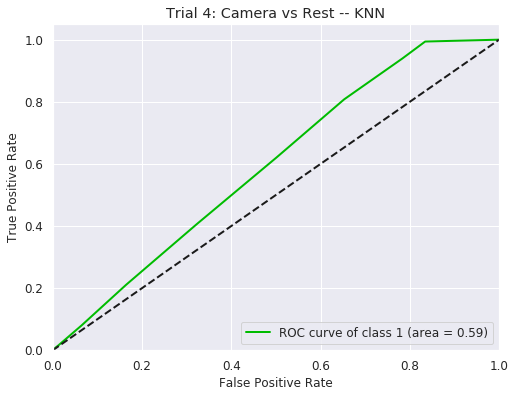

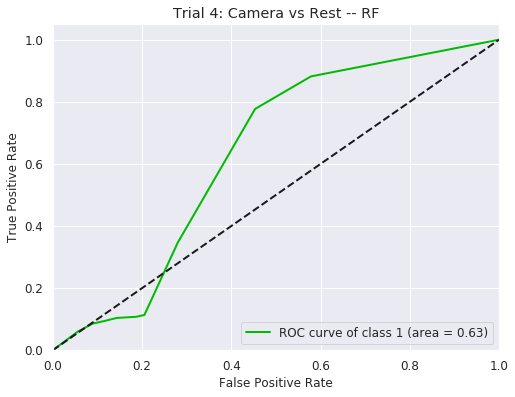

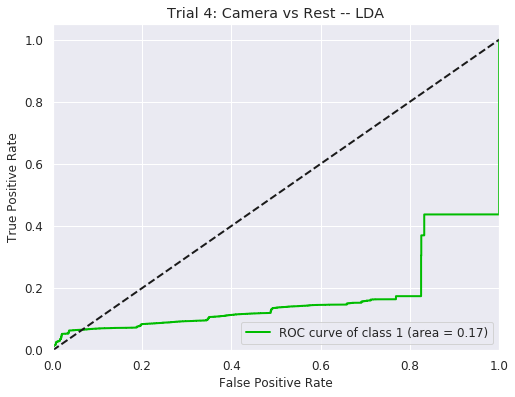

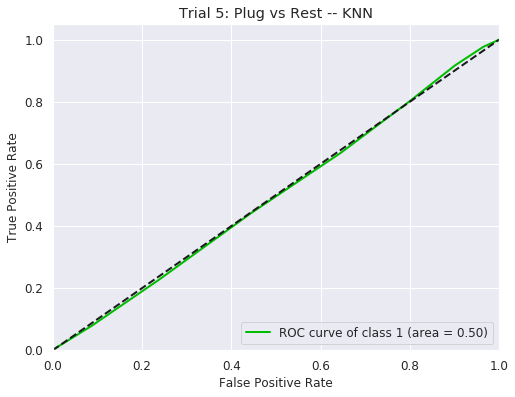

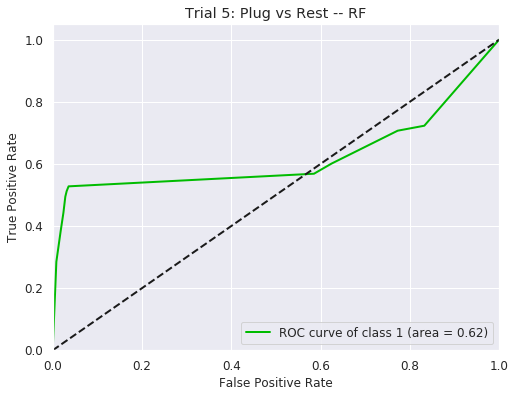

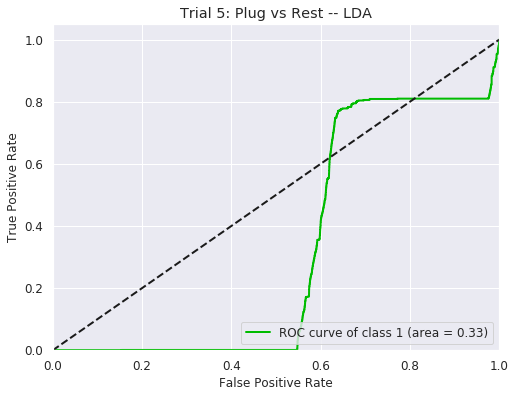

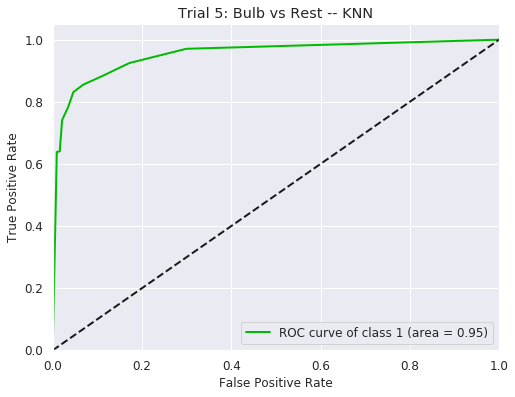

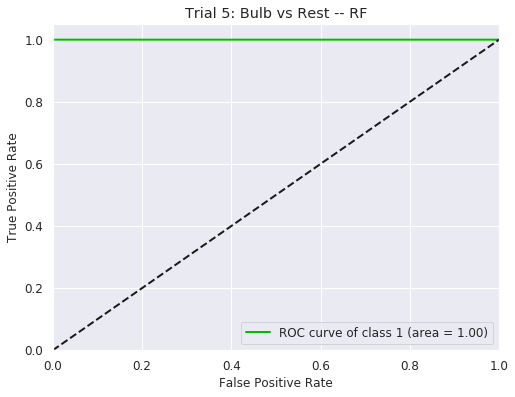

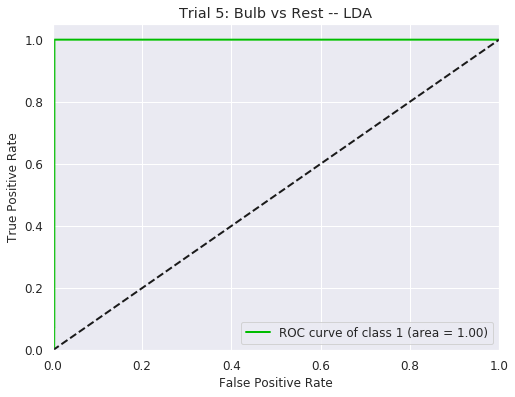

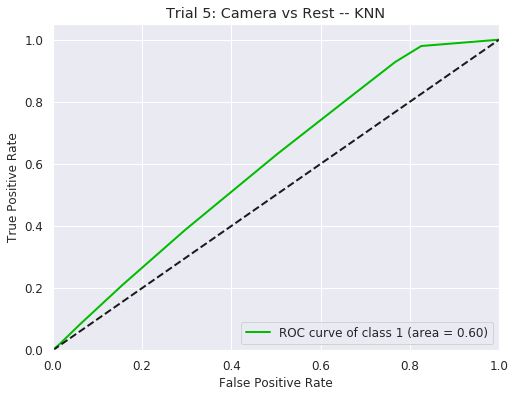

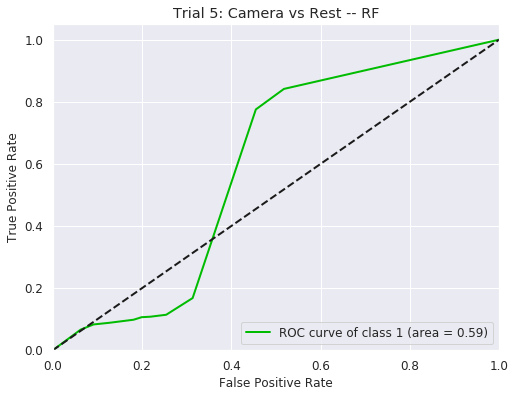

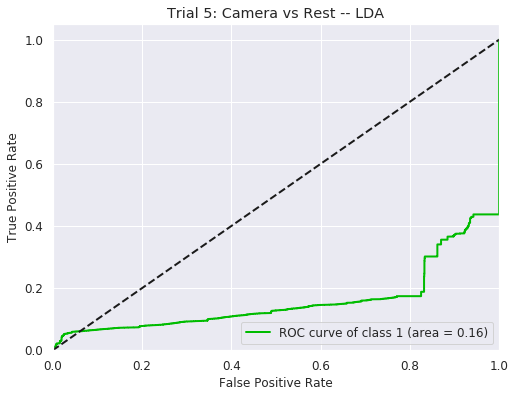

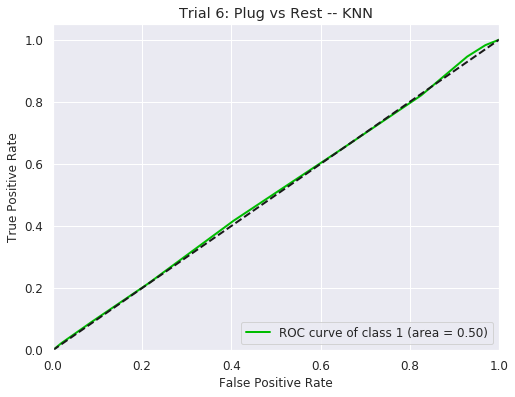

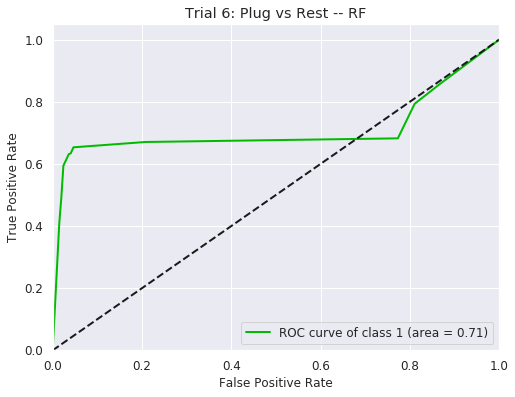

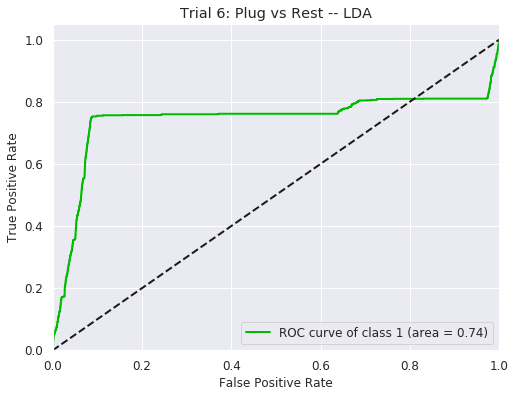

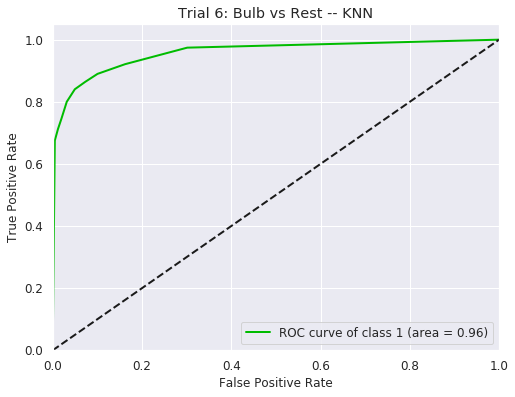

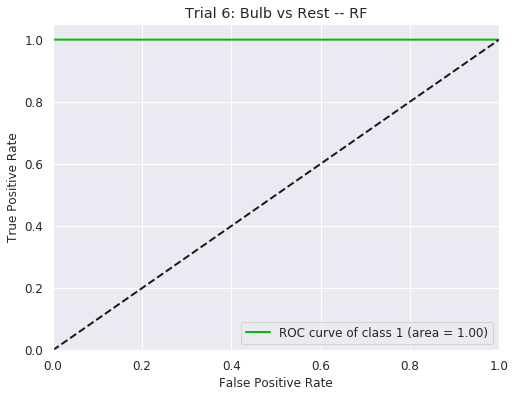

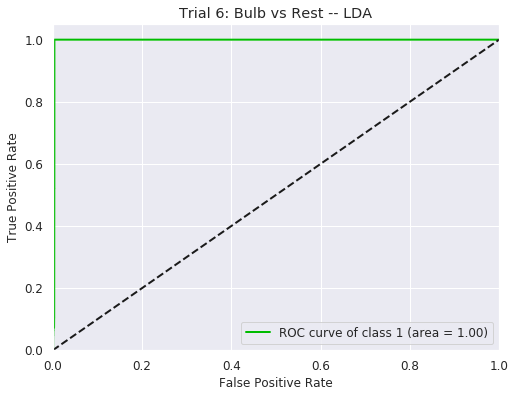

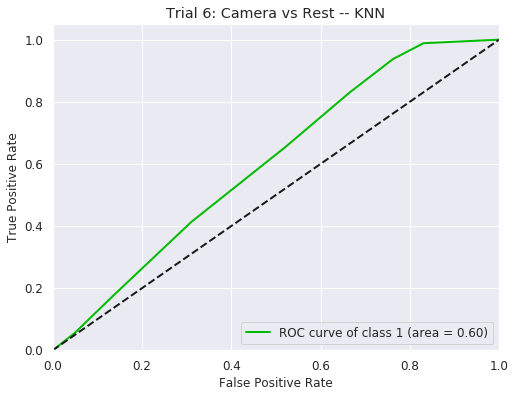

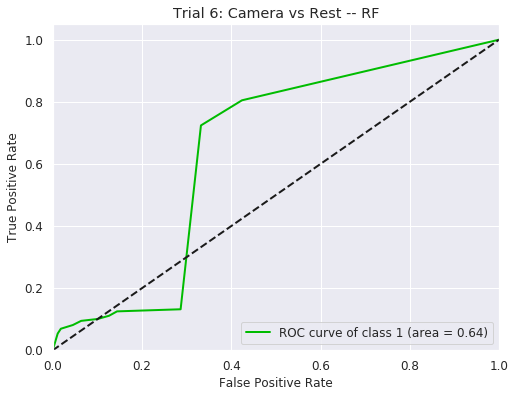

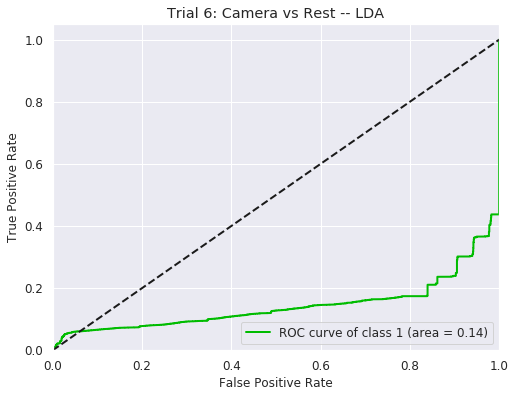

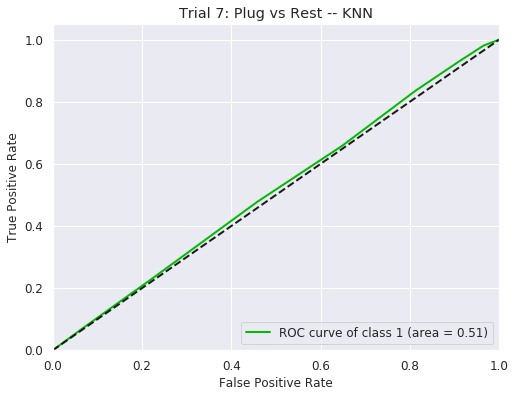

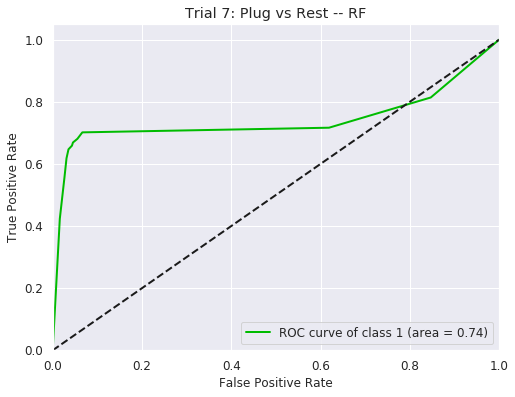

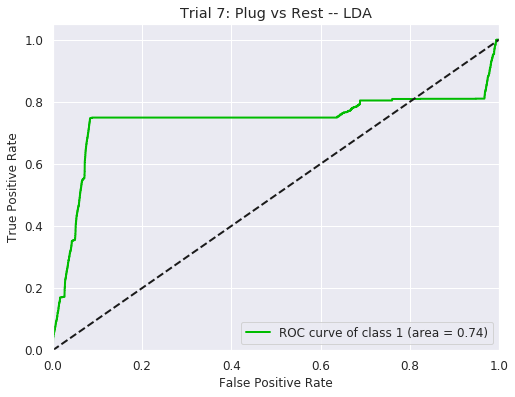

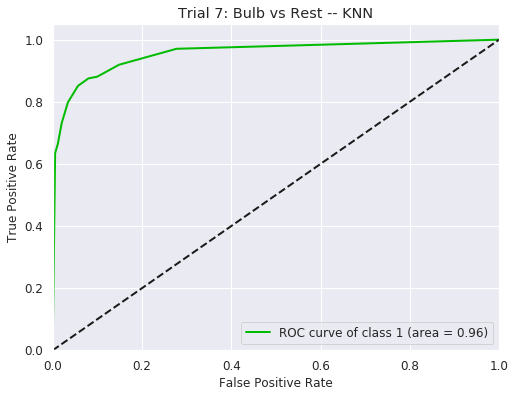

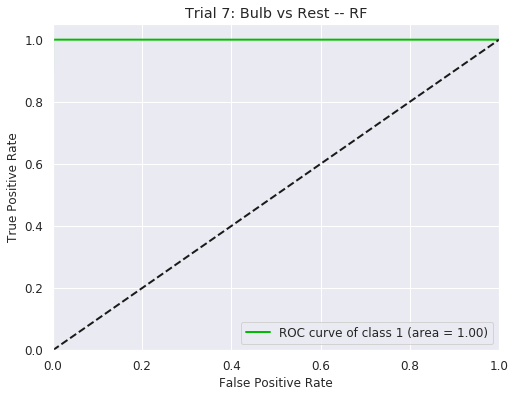

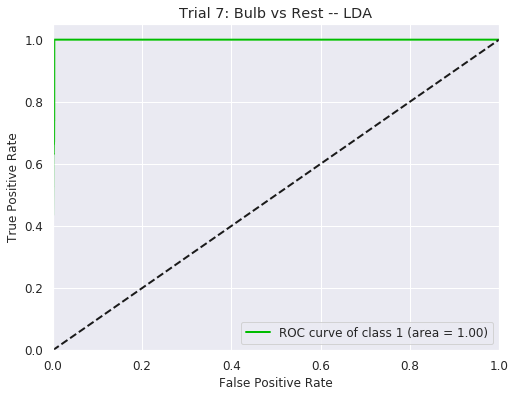

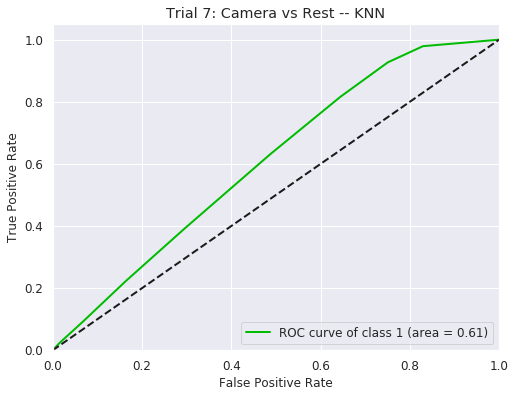

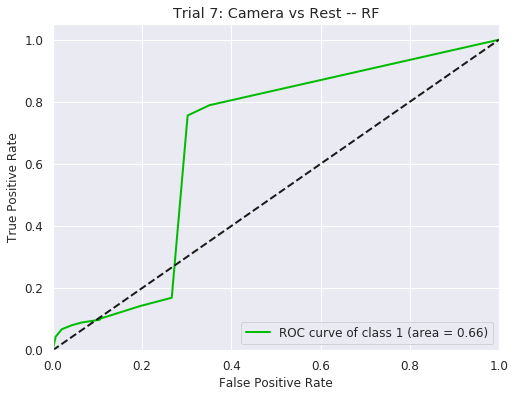

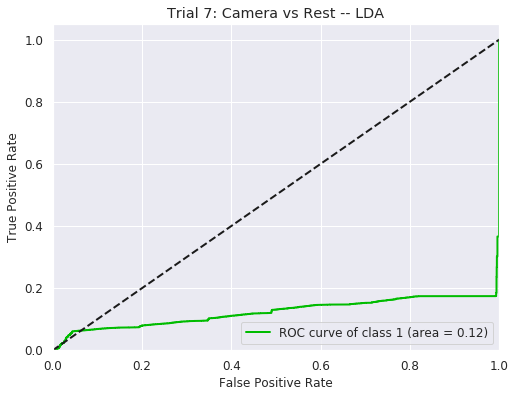

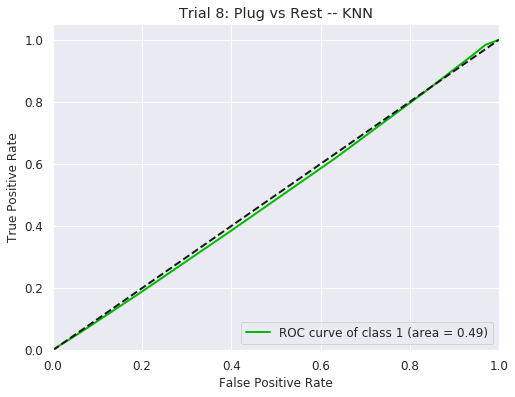

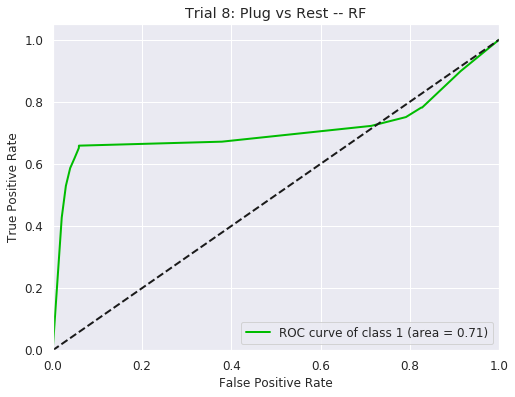

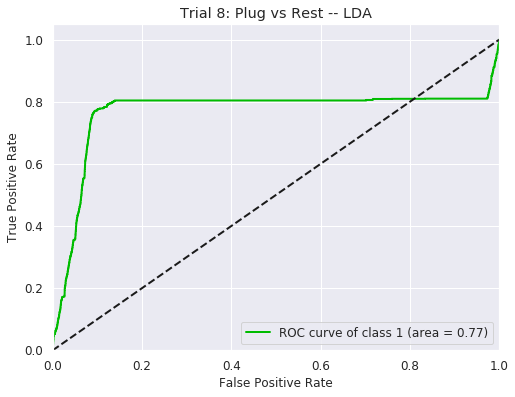

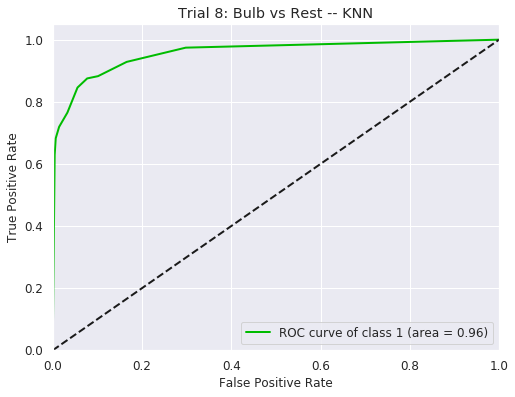

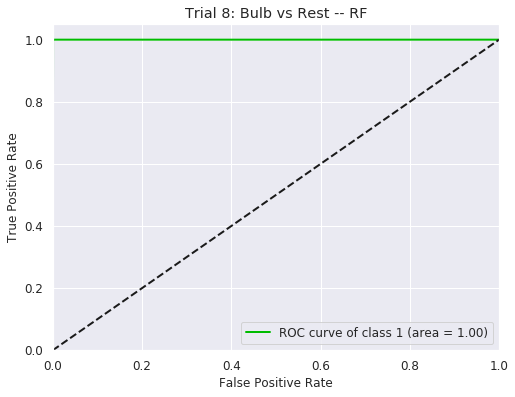

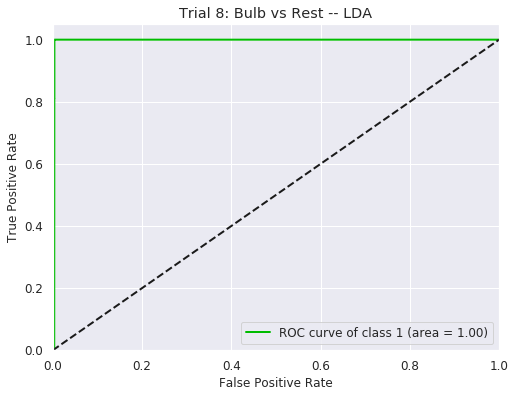

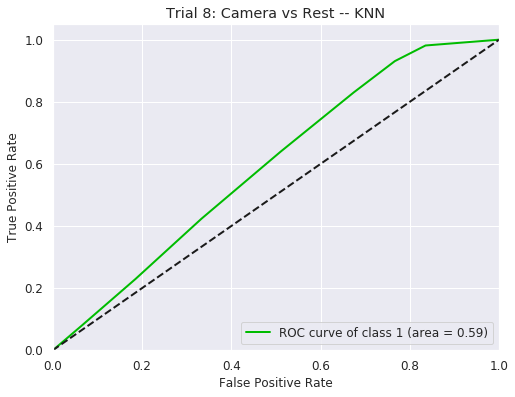

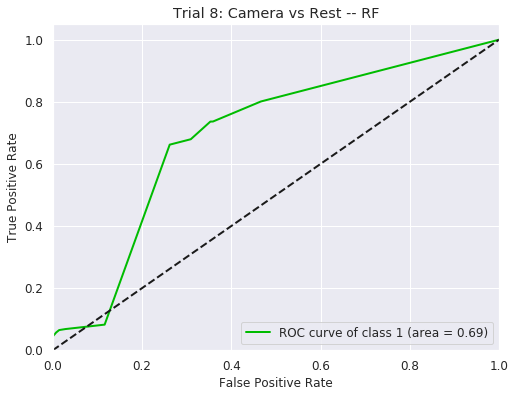

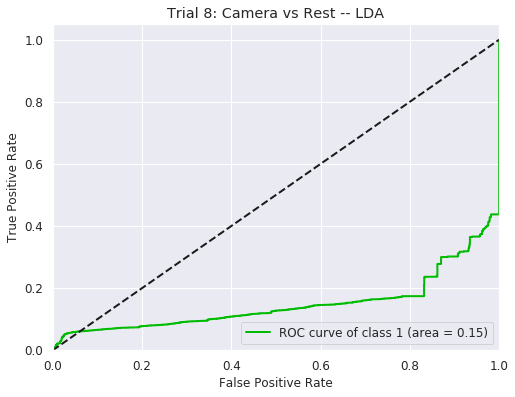

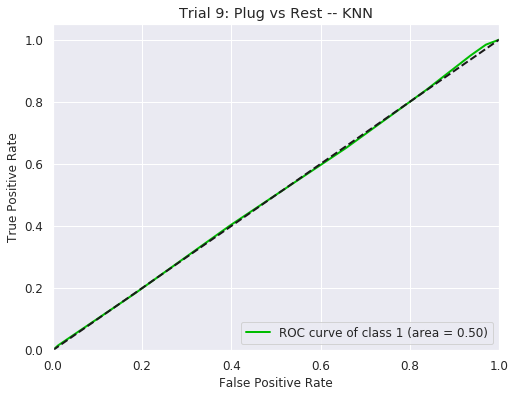

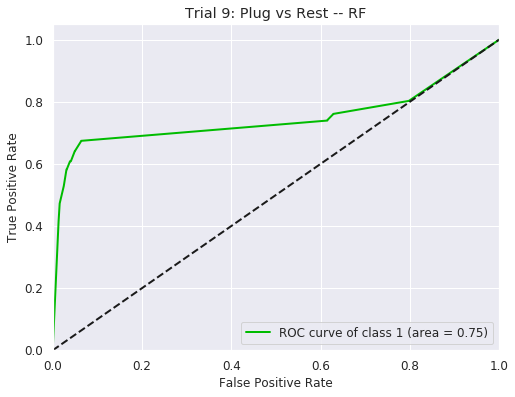

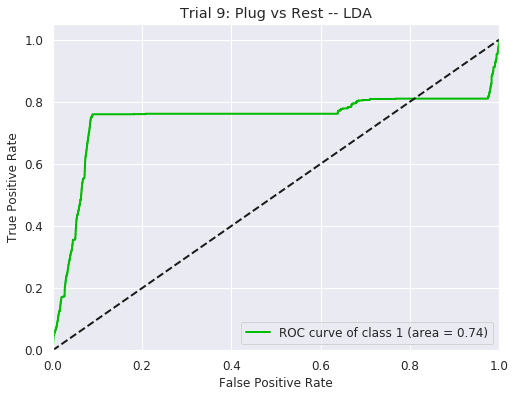

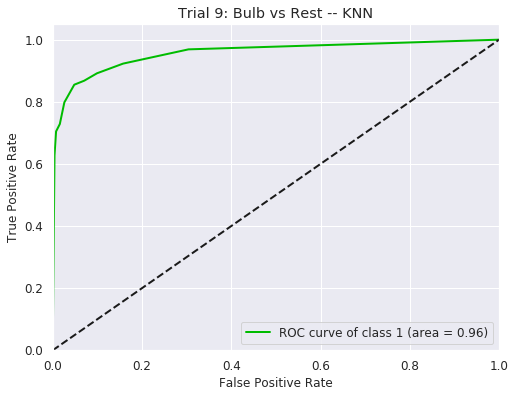

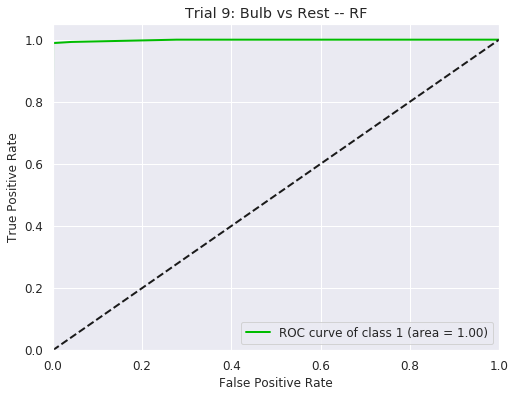

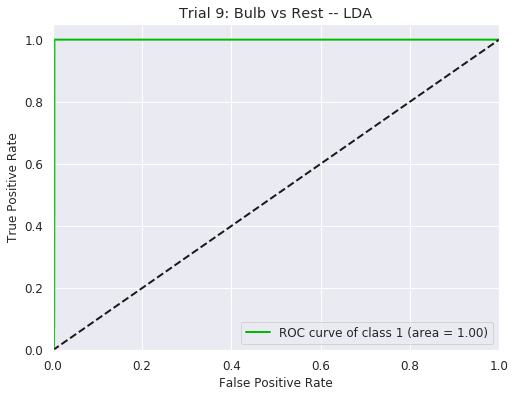

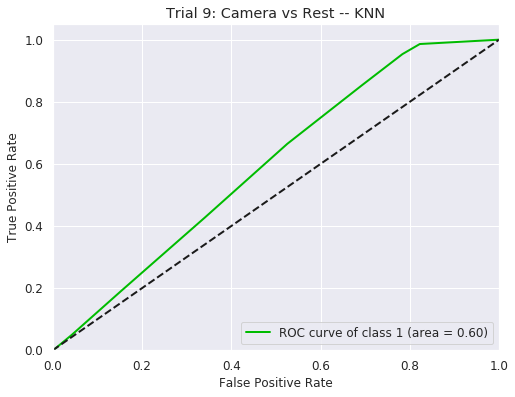

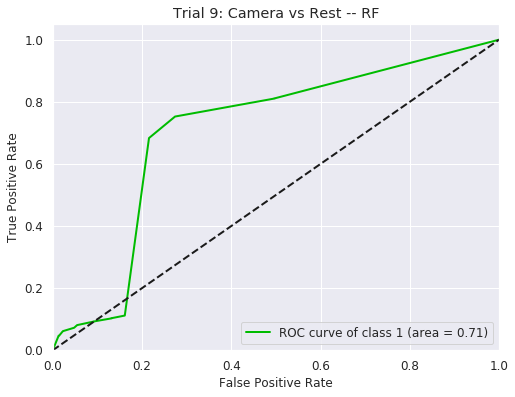

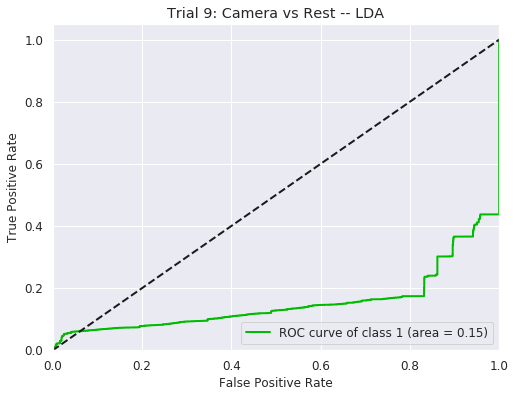

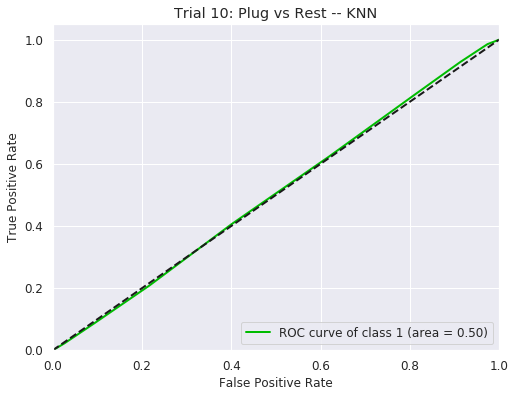

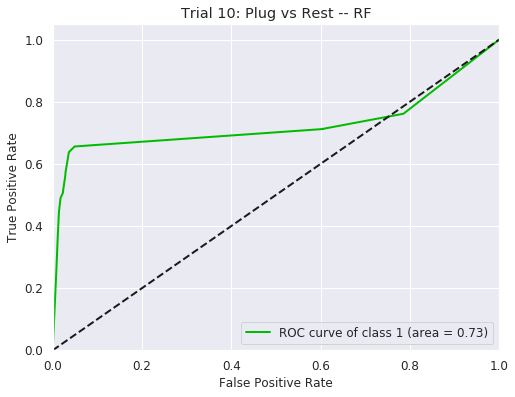

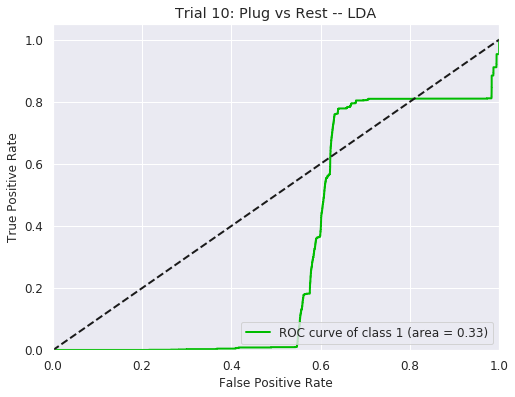

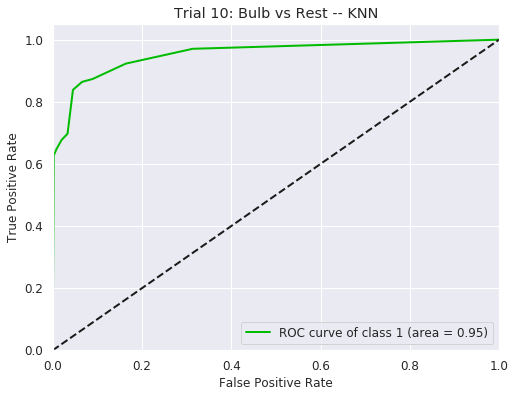

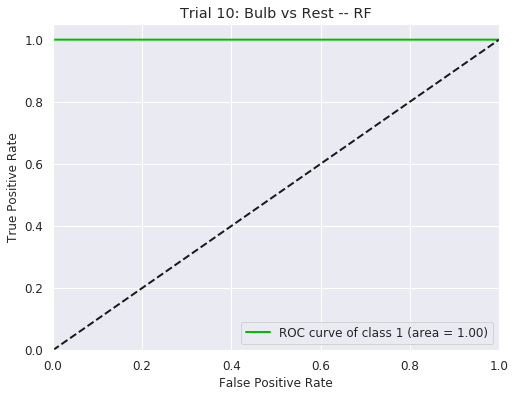

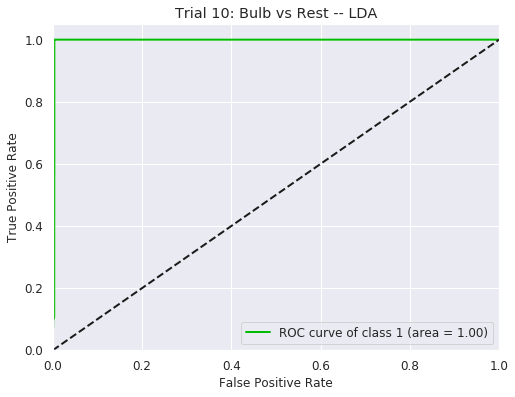

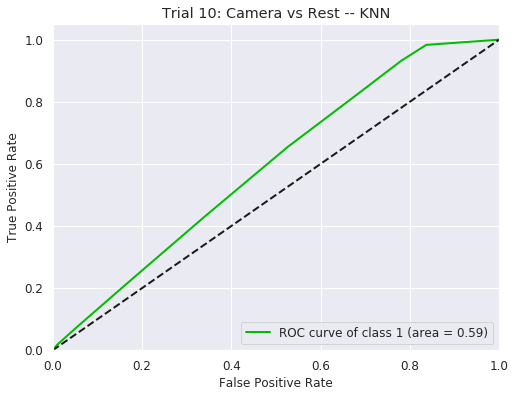

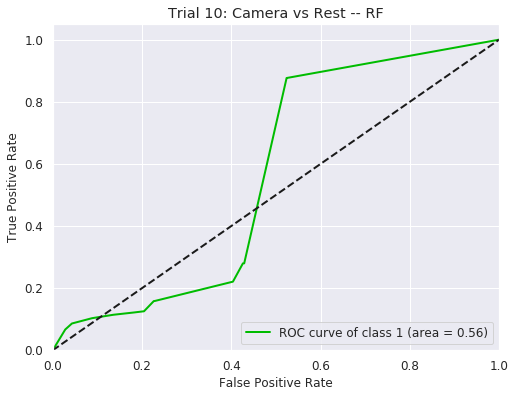

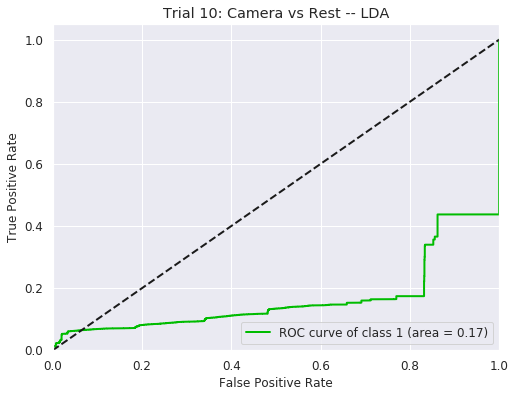

In [19]:
# Plotting ROC curves
sns.set(font_scale=1)

for trial_num, result in enumerate(trial_results):
    # Extract devices and classifiers
    dev_pairs = result[0].keys()
    classifiers = result[0][dev_pairs[0]].keys()

    for device in dev_pairs:
        for classifier in classifiers:
            # Extract predicted probas and y_true
            pred_proba = result[0][device][classifier]['Classifier']['Pred_Proba']
            true = result[0][device][classifier]['Classifier']['True']

            # Plot ROC curve
            fpr, tpr, threshold = roc_curve(true, pred_proba[:,1], pos_label=1)
            auc = roc_auc_score(true, pred_proba[:,1])
            title = "Trial " + str(trial_num + 1) + ": " + str(device).capitalize() + " vs Rest -- " + str(classifier).upper() 
            skplt.metrics.plot_roc(true, pred_proba, title=title, plot_micro=False, plot_macro=False, 
                                   classes_to_plot=[1], figsize=(8,6));

### Time Performance

In [20]:
for trial_num, result in enumerate(trial_results):
    print "Trial ", trial_num
    print "Total time:", result[1], "seconds"
    
    for device in device_types:
        for classifier in classifiers:
            title = "("+ str(device).capitalize() + ", "+str(classifier).upper() + ")"
            print title, ":", result[0][device][classifier]['Classifier']['Time'], "seconds"
    
    print ""

Trial  0
Total time: 1.37434601784 seconds
(Bulb, KNN) : 0.210549116135 seconds
(Bulb, RF) : 0.0537481307983 seconds
(Bulb, LDA) : 0.00686717033386 seconds
(Camera, KNN) : 0.229606151581 seconds
(Camera, RF) : 0.0645699501038 seconds
(Camera, LDA) : 0.00784087181091 seconds
(Plug, KNN) : 0.218955993652 seconds
(Plug, RF) : 0.0557689666748 seconds
(Plug, LDA) : 0.00723505020142 seconds

Trial  1
Total time: 1.34514904022 seconds
(Bulb, KNN) : 0.209058046341 seconds
(Bulb, RF) : 0.0538368225098 seconds
(Bulb, LDA) : 0.00699281692505 seconds
(Camera, KNN) : 0.221138954163 seconds
(Camera, RF) : 0.0601809024811 seconds
(Camera, LDA) : 0.00696802139282 seconds
(Plug, KNN) : 0.210566043854 seconds
(Plug, RF) : 0.0597939491272 seconds
(Plug, LDA) : 0.00725197792053 seconds

Trial  2
Total time: 1.3512160778 seconds
(Bulb, KNN) : 0.213140010834 seconds
(Bulb, RF) : 0.053365945816 seconds
(Bulb, LDA) : 0.00699186325073 seconds
(Camera, KNN) : 0.21537399292 seconds
(Camera, RF) : 0.060054063797 

### Feature Importance

In [21]:
df_featImp = pd.DataFrame()
for i,f in enumerate(w.feature_importances):
    f_i = pd.Series(f, index=features_list)
    df_featImp[i] = f_i

In [22]:
import numpy as np, scipy.stats as st
a = df_featImp.iloc[:,0:30].T
lower, upper = st.t.interval(0.90, len(a)-1, loc=np.mean(a), scale=st.sem(a))

/root/anaconda2/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:1910: RuntimeWarning: invalid value encountered in multiply
  lower_bound = self.a * scale + loc
/root/anaconda2/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:1911: RuntimeWarning: invalid value encountered in multiply
  upper_bound = self.b * scale + loc


In [23]:
df_featImp['Mean'] = df_featImp.mean(axis=1)
df_featImp['StdDev'] = df_featImp.std(axis=1)
df_featImp['CI_Lower'] = lower
df_featImp['CI_Upper'] = upper

In [24]:
display(df_featImp[['Mean', 'StdDev', 'CI_Lower', 'CI_Upper']].sort_values('Mean', ascending=False))

,Mean,StdDev,CI_Lower,CI_Upper
Belkin,0.223284,0.190420,0.163203,0.283366
PacketLength,0.206233,0.162750,0.154882,0.257584
Dropcam,0.188529,0.213086,0.121296,0.255762
QoS_Null,0.134324,0.094447,0.104524,0.164124
Assoc_Packets,0.116162,0.077749,0.091631,0.140693
Lifi,0.054215,0.060679,0.035069,0.073361
QoS_Data,0.030242,0.035888,0.018919,0.041566
Time,0.027687,0.016764,0.022398,0.032976
Data,0.014439,0.012740,0.010420,0.018459
Tp-link,0.004883,0.009210,0.001977,0.007789


### Sampling Counts

In [25]:
print "Packet Counts Prior to Resampling"
print df["DeviceType"].value_counts()

Packet Counts Prior to Resampling
plug      85512
camera    71399
bulb       1231
Name: DeviceType, dtype: int64


Training Set plug      83642
camera    51282
bulb        686
Name: DeviceType, dtype: int64

Test Set camera    20117
plug       1870
bulb        545
Name: DeviceType, dtype: int64


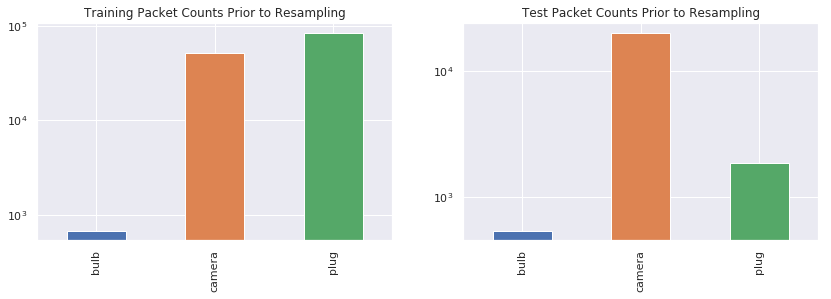

In [26]:
plt.subplots(1, 2, figsize=(14,4)) # number of rows, number of columns, figure size=(width, height)

# Plot training set
df_train = df[df["Set"]=="train"]
plt.subplot(1, 2, 1)
df_train["DeviceType"].value_counts().sort_index().plot(kind='bar', title="Training Packet Counts Prior to Resampling", logy=True);
print "Training Set", df_train["DeviceType"].value_counts()
print

# Plot test set
df_test = df[df["Set"]=="test"]
plt.subplot(1, 2, 2)
df_test["DeviceType"].value_counts().sort_index().plot(kind='bar', title="Test Packet Counts Prior to Resampling", logy=True);
print "Test Set", df_test["DeviceType"].value_counts()

/root/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


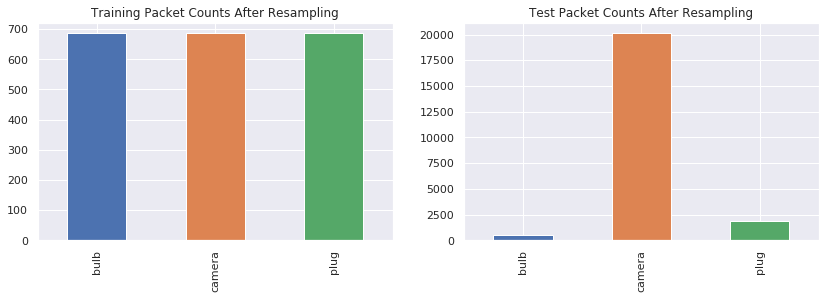

In [27]:
# Plot post-sampling
plt.subplots(1, 2, figsize=(14,4)) # number of rows, number of columns, figure size=(width, height)

df_train_downsampled = df_trials[0][df_trials[0]['Set']=='train']
df_test_downsampled = df_trials[0][df_trials[0]['Set']=='test']

# Plot training set
df_train_downsampled['DeviceType'] = df_train_downsampled[['bulb','camera','plug']].idxmax(1)
plt.subplot(1, 2, 1)
df_train_downsampled['DeviceType'].value_counts().sort_index().plot(kind='bar', title="Training Packet Counts After Resampling");

# Plot test set
df_test = df[df["Set"]=="test"]
plt.subplot(1, 2, 2)
df_test["DeviceType"].value_counts().sort_index().plot(kind='bar', title="Test Packet Counts After Resampling");
